In [1]:
# =========================================================
# Nested NPIV with sparse (L1) linear estimators
# =========================================================

import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from threadpoolctl import threadpool_limits

# Limit native threads to avoid oversubscription during CV/LA
threadpool_limits(1)

# -----------------------------------------
# Local repo imports (adjust path if needed)
# -----------------------------------------
sys.path.append(str(Path.cwd() / "../../simulations"))
import dgps_nested as dgps  # noqa: E402

from nnpiv.linear import (  # noqa: E402
    sparse_l1vsl1,
    sparse_ridge_l1vsl1,
    sparse2_l1vsl1,
    sparse2_ridge_l1vsl1,
)

# ---------
# Settings
# ---------
plt.style.use("seaborn-v0_8-white")
plt.rcParams["figure.dpi"] = 120

def seed_everything(seed: int = 123) -> None:
    np.random.seed(seed)

seed_everything(123)

# =========================================================
# Data generation 
# =========================================================
# Function dictionary (for reference):
# {'abs': 0, '2dpoly': 1, 'sigmoid': 2, 'sin': 3, 'frequent_sin': 4, 'abs_sqrt': 5,
#  'step': 6, '3dpoly': 7, 'linear': 8, 'rand_pw': 9, 'abspos': 10, 'sqrpos': 11,
#  'band': 12, 'invband': 13, 'steplinear': 14, 'pwlinear': 15, 'exponential': 16}

fn_number = 15
tau_fn = dgps.get_tau_fn(fn_number)

# A, D are first stage (endog + instruments); B, C are second stage; Y is outcome
A, D, B, C, Y, tau_fn = dgps.get_data(3000, 10, 10, tau_fn, 2)

# ---------------------------------------
# Build test grid (vary B[:,0] for plots)
# ---------------------------------------
def make_test_grid(X: np.ndarray, var_idx: int = 0, n: int = 1000,
                   q_low: float = 5.0, q_high: float = 95.0) -> np.ndarray:
    """
    Sweep one coordinate (var_idx) between given quantiles; hold others at median.
    Returns a grid sorted by the swept coordinate.
    """
    grid = np.tile(np.median(X, axis=0, keepdims=True), (n, 1))
    grid[:, var_idx] = np.linspace(
        np.percentile(X[:, var_idx], q_low),
        np.percentile(X[:, var_idx], q_high),
        n,
    )
    return grid[np.argsort(grid[:, var_idx])]

B_test = make_test_grid(B, var_idx=0, n=1000)
true_fn = tau_fn(B_test)

# ---------------------------------------------------------
# Sequential nested NPIV using sparse (L1) linear models
# ---------------------------------------------------------
def nested_npivfit(
    A: np.ndarray, B: np.ndarray, C: np.ndarray, D: np.ndarray, Y: np.ndarray,
    B_test: np.ndarray,
    model,
    fitargs: dict | None = None,
    deg: int = 3,
) -> np.ndarray:
    """
    Two-step baseline:
      Stage 1: fit g(A) using instruments D
      Stage 2: fit h(B) using instruments C, target = g_hat(A)

    If `fitargs` is None, we build polynomial features of degree `deg`
    for both instrument and treatment at each stage.
    """
    # Rename for clarity
    A1, B1, A2, B2 = A, B, D, C

    # Build polynomial features if not passing raw fitargs
    if fitargs is None:
        trans_A = PolynomialFeatures(degree=deg, include_bias=False)
        ZA = trans_A.fit_transform(A2)
        TA = trans_A.fit_transform(A1)
    else:
        ZA, TA = A2, A1

    # Stage 1: estimate g(A) with instruments D
    if fitargs is not None:
        model.fit(ZA, TA, Y, **fitargs)
    else:
        model.fit(ZA, TA, Y)

    g_hat = model.predict(TA).reshape(A1.shape[0], -1)

    # Stage 2 (on B, C)
    if fitargs is None:
        trans_B = PolynomialFeatures(degree=deg, include_bias=False)
        ZB = trans_B.fit_transform(B2)
        TB = trans_B.fit_transform(B1)
        TB_test = trans_B.transform(B_test)
    else:
        ZB, TB, TB_test = B2, B1, B_test

    if fitargs is not None:
        model.fit(ZB, TB, g_hat, **fitargs)
    else:
        model.fit(ZB, TB, g_hat)

    y_pred_test = model.predict(TB_test).reshape(B_test.shape[0], -1)
    return y_pred_test

In [2]:
# -----------------------------
# Models & predictions
# -----------------------------

# Stagewise sparse L1 (deg=3)
splin_1 = sparse_l1vsl1(
    B=10, lambda_theta=0.1, eta_theta=0.1, eta_w=0.1,
    n_iter=10_000, tol=1e-4, sparsity=None
)
splin_1_pred = nested_npivfit(A, B, C, D, Y, B_test, model=splin_1, deg=3)

# Stagewise sparse ridge-L1 (deg=3)
splin_2 = sparse_ridge_l1vsl1(
    B=10, lambda_theta=0.025, eta_theta=0.1, eta_w=0.1,
    n_iter=20_000, tol=1e-4, sparsity=None
)
splin_2_pred = nested_npivfit(A, B, C, D, Y, B_test, model=splin_2, deg=3)

# Joint (simultaneous) sparse variants
# For these, the original code expands with PolynomialFeatures(deg=3) outside
# and feeds transformed arrays into .fit/.predict directly.
trans = PolynomialFeatures(degree=3, include_bias=False)
A3 = trans.fit_transform(A)
B3 = trans.fit_transform(B)
C3 = trans.fit_transform(C)
D3 = trans.fit_transform(D)
B3_test = trans.transform(B_test)

splin3 = sparse2_l1vsl1(
    mu=0.1, V1=10, V2=10,
    eta_alpha="auto", eta_w1="auto", eta_beta="auto", eta_w2="auto",
    n_iter=10_000, tol=5e-5, sparsity=None, fit_intercept=True
)
splin3_pred = splin3.fit(A3, B3, C3, D3, Y).predict(B3_test)

splin4 = sparse2_ridge_l1vsl1(
    mu=0.025, V1=10, V2=10,
    eta_alpha="auto", eta_w1="auto", eta_beta="auto", eta_w2="auto",
    n_iter=20_000, tol=5e-5, sparsity=None, fit_intercept=True
)
splin4_pred = splin4.fit(A3, B3, C3, D3, Y).predict(B3_test)

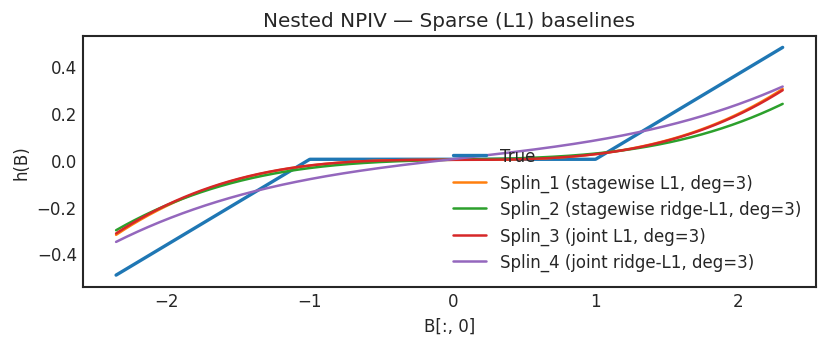

In [3]:
# ----------
# Plotting
# ----------
plt.figure(figsize=(7, 3))
plt.plot(B_test[:, 0], true_fn, label="True", linewidth=2)
plt.plot(B_test[:, 0], splin_1_pred.ravel(), label="Splin_1 (stagewise L1, deg=3)")
plt.plot(B_test[:, 0], splin_2_pred.ravel(), label="Splin_2 (stagewise ridge-L1, deg=3)")
plt.plot(B_test[:, 0], splin3_pred.ravel(), label="Splin_3 (joint L1, deg=3)")
plt.plot(B_test[:, 0], splin4_pred.ravel(), label="Splin_4 (joint ridge-L1, deg=3)")
plt.xlabel("B[:, 0]")
plt.ylabel("h(B)")
plt.legend(frameon=False)
plt.title("Nested NPIV — Sparse (L1) baselines")
plt.tight_layout()
plt.show()